<a href="https://colab.research.google.com/github/PauloRicardo09/PauloRicardo09/blob/main/Agente_DQN_em_um_Ambiente_de_Mercado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agente DQN em um Ambiente de Mercado

## Introdução
Este código implementa um agente de aprendizado por reforço utilizando a técnica de Deep Q-Learning (DQN) para otimizar preços de produtos em um ambiente de mercado simulado. O objetivo é maximizar o lucro ajustando os preços com base na demanda.

---

## Estrutura do Código

### 1. Ambiente de Mercado (`MarketEnv`)

**Objetivo**: Simular um ambiente onde produtos têm preços e demanda.

- **Método `__init__`**:
  - Inicializa o ambiente com preços aleatórios para cada produto.
  - Cria um histórico para armazenar a evolução dos preços.

- **Método `step`**:
  - Recebe um produto e uma ação (ajuste de preço).
  - Calcula o novo preço, a demanda e a receita.
  - Retorna uma recompensa proporcional ao lucro obtido, penalizando mudanças bruscas de preço.

- **Método `reset`**:
  - Reinicia o estado do ambiente, gerando novos preços aleatórios.
  - Retorna o estado inicial dos preços.

**Uso**: Este ambiente permite que o agente interaja e aprenda a otimizar preços com base nas respostas do mercado.

---

### 2. Modelo DQN (`DQN`)

**Objetivo**: Definir a rede neural que estima os valores das ações.

- **Estrutura**:
  - Contém três camadas totalmente conectadas (fully connected).
  - Utiliza a função de ativação ReLU para introduzir não-linearidades.

- **Método `forward`**:
  - Processa a entrada (estado do ambiente) e produz valores para cada ação possível.

**Uso**: A rede neural é fundamental para que o agente aprenda a prever os resultados de suas ações no ambiente.

---

### 3. Agente Double DQN (`DoubleDQNAgent`)

**Objetivo**: Utilizar a rede DQN para tomar decisões de forma mais estável e eficiente.

- **Características**:
  - Implementa a técnica Double DQN, que utiliza um modelo alvo para melhorar a estabilidade do aprendizado.
  - Armazena experiências em um buffer de replay, permitindo que o agente aprenda de interações passadas.

- **Métodos**:
  - **`act`**: Decide a ação a ser tomada com base no estado atual, utilizando uma política de exploração (ε-greedy).
  - **`remember`**: Armazena a experiência (estado, ação, recompensa, próximo estado) no buffer de replay.
  - **`train`**: Treina a rede neural usando um lote de experiências do buffer, ajustando os pesos da rede para minimizar a perda.

**Uso**: O agente é responsável por interagir com o ambiente, coletar recompensas e aprender a otimizar os preços.

---

### 4. Treinamento e Teste

**Objetivo**: Treinar o agente para otimizar preços e maximizar lucros.

- **Processo**:
  - Um loop de treinamento onde o agente interage com o ambiente, ajusta preços e acumula recompensas.
  - O agente é treinado em múltiplos episódios, onde a política é atualizada a cada interação.
  - Após o treinamento, o agente é testado para sugerir novos preços com base no estado atual do mercado.

**Uso**: Essa fase é crucial para que o agente aprenda a melhor estratégia de precificação ao longo do tempo.

---

## Conclusão

Este código é um exemplo prático de como aplicar técnicas de aprendizado por reforço em um ambiente de mercado. O agente DQN aprende a otimizar preços com base na demanda, permitindo simulações de estratégias de precificação e potencialmente melhorando a lucratividade em cenários do mundo real, como e-commerce e gestão de produtos.

---

## Aplicações Práticas

- **Otimização de Preços**: Ajuste dinâmico de preços em plataformas de e-commerce.
- **Simulações de Mercado**: Teste de diferentes estratégias de precificação e análise de impacto na demanda.
- **Aprendizado por Reforço**: Demonstração de como agentes podem aprender a partir de interações com o ambiente.

Episódio 0, Recompensa Total: 2253.86, Epsilon: 1.000
Episódio 50, Recompensa Total: 1766.41, Epsilon: 0.782
Episódio 100, Recompensa Total: 1082.94, Epsilon: 0.609
Episódio 150, Recompensa Total: 1925.76, Epsilon: 0.474
Episódio 200, Recompensa Total: 623.40, Epsilon: 0.369
Episódio 250, Recompensa Total: 1187.84, Epsilon: 0.287
Episódio 300, Recompensa Total: 711.33, Epsilon: 0.223
Episódio 350, Recompensa Total: 684.34, Epsilon: 0.174
Episódio 400, Recompensa Total: 1353.28, Epsilon: 0.135
Episódio 450, Recompensa Total: 1071.74, Epsilon: 0.105
Preços iniciais: [39.19160389440212, 41.58319332122077, 26.09170327727403]
Novos preços sugeridos pelo NPC: [40.19160389440212, 42.58319332122077, 27.09170327727403]
Novos preços sugeridos pelo NPC: [41.19160389440212, 43.58319332122077, 28.09170327727403]
Novos preços sugeridos pelo NPC: [42.19160389440212, 44.58319332122077, 29.09170327727403]
Novos preços sugeridos pelo NPC: [41.19160389440212, 43.58319332122077, 28.09170327727403]
Novos p

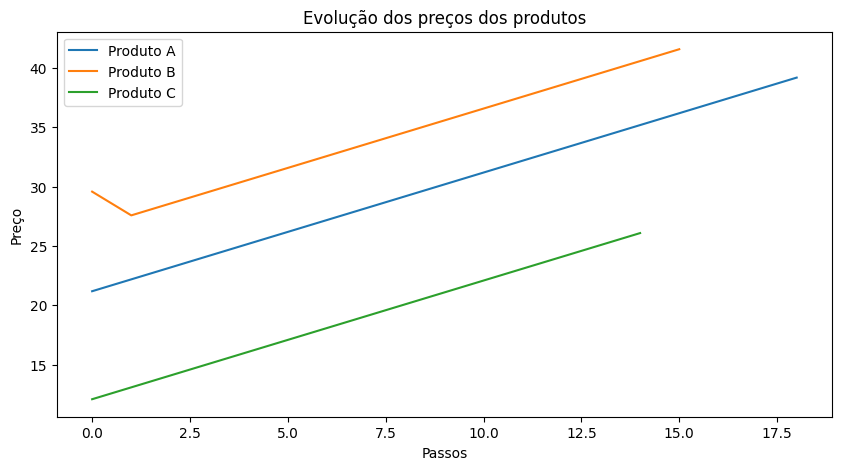

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Configuração do ambiente
np.random.seed(42)
torch.manual_seed(42)

class MarketEnv:
    def __init__(self, products):
        self.products = products
        self.state = {p: random.uniform(10, 40) for p in products}  # Estado inicial com preços aleatórios
        self.history = {p: [] for p in products}

    def step(self, product, action):
        price = self.state[product] + action  # Ação ajusta o preço
        price = max(1, min(50, price))  # Limita dentro do intervalo

        demand = max(self.products[product]["a"] - self.products[product]["b"] * price + np.random.normal(0, 5), 0)
        revenue = (price - self.products[product]["cost"]) * demand

        # Nova função de recompensa proporcional ao retorno do vendedor
        profit_margin = (revenue / max(1, (self.products[product]["a"] * self.products[product]["cost"]))) * 100
        reward = profit_margin - abs(action) * 2  # Penaliza mudanças bruscas de preço

        self.state[product] = price
        self.history[product].append(price)
        return reward

    def reset(self):
        self.state = {p: random.uniform(10, 40) for p in self.products}
        self.history = {p: [] for p in self.products}
        return [self.state[p] for p in self.products]  # Retorna o estado inicial

# Definição do agente Double DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DoubleDQNAgent:
    def __init__(self, env, lr=0.0005, gamma=0.99):
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.memory = deque(maxlen=20000)
        self.model = DQN(len(env.products), 5)  # 5 ações possíveis
        self.target_model = DQN(len(env.products), 5)  # Modelo alvo
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([-2, -1, 0, 1, 2])  # Ações possíveis
        state_tensor = torch.FloatTensor([state])
        with torch.no_grad():
            action_values = self.model(state_tensor)
        return torch.argmax(action_values).item() - 2  # Convertendo para [-2, -1, 0, 1, 2]

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def train(self, batch_size=128):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            state_tensor = torch.FloatTensor([state])
            next_state_tensor = torch.FloatTensor([next_state])
            target = reward + self.gamma * self.target_model(next_state_tensor).detach().max().item()
            target_f = self.model(state_tensor).clone().detach()
            target_f[0, action + 2] = target  # Ajuste do índice corretamente para o novo tamanho

            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state_tensor), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Inicializando ambiente e agente
products = {
    "Produto A": {"a": 120, "b": 2.5, "cost": 15},
    "Produto B": {"a": 80, "b": 1.8, "cost": 8},
    "Produto C": {"a": 150, "b": 3, "cost": 20}
}

env = MarketEnv(products)
agent = DoubleDQNAgent(env)

episodes = 500
for episode in range(episodes):
    total_reward = 0
    state = env.reset()  # Usa todos os produtos no estado
    for _ in range(50):  # 50 passos por episódio
        product = random.choice(list(env.products.keys()))  # Escolhe um produto aleatoriamente
        action = agent.act(state)
        reward = env.step(product, action)
        next_state = [env.state[p] for p in env.products]
        agent.remember(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    agent.train()
    agent.update_target_model()  # Atualiza o modelo alvo a cada episódio
    if episode % 50 == 0:
        print(f"Episódio {episode}, Recompensa Total: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

# Teste do NPC após treinamento
state = [env.state[p] for p in env.products]
print("Preços iniciais:", state)
for _ in range(10):
    action = agent.act(state)
    state = [max(1, min(50, s + action)) for s in state]
    print("Novos preços sugeridos pelo NPC:", state)

# Plotando a variação dos preços ao longo do tempo
plt.figure(figsize=(10, 5))
for product, prices in env.history.items():
    plt.plot(prices, label=product)
plt.xlabel("Passos")
plt.ylabel("Preço")
plt.title("Evolução dos preços dos produtos")
plt.legend()
plt.show()